# Scikit learn Tree

In [1]:
import os
import sys
import re
import random
import math
import scipy
import numpy as np
import pandas as pd
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold # import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline


from mpl_toolkits.mplot3d import Axes3D
cmapRdYlGn = cm.get_cmap('RdYlGn')
cmap = cm.coolwarm


challenge_data_folder = "./challenge_data"

from minisom import MiniSom
#outlier detection http://scikit-learn.org/stable/modules/outlier_detection.html

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
##Data cleaning
pdAllData_Categ = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False) #Load training data NA filter FALSE to keep Not available data
columnTypesDict = pdAllData_Categ.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name

pathDescr = (challenge_data_folder+"/Data description.rtf")
txtDescripData = open(pathDescr).readlines()
columnValues={}
columnIndex=[]
nbHeader = 7
NoHeaderTxtDescripData = txtDescripData[nbHeader:]
for feature in columnNames:
    if feature == 'Id': continue
    for index,line in enumerate(NoHeaderTxtDescripData):
        if feature in line:
            if(line.split(feature)[0]=='' and line.split(feature)[1][0]==':' ): #Make sure exactly this feature in this line 
                columnIndex.append((feature,index))
            pass
        
NoSpecificValfeatures = []
SpecificVal = {} #Will contain as keys column names and values the specified values in the description file

for index,featureLine in enumerate(columnIndex):
    
    startLine= featureLine[1]+2
    if index == len(columnIndex)-1: endLine = len(NoHeaderTxtDescripData)-1
    else: endLine = columnIndex[index+1][1]-1
    values = []
    if endLine <= startLine: #No specified value in the description file
        if featureLine[0]=='Heating': print(columnIndex[index])
        NoSpecificValfeatures.append(featureLine[0])
        continue
    for i in range(startLine,endLine):
        line = NoHeaderTxtDescripData[i] 
        values.append(line.split('\t')[0].strip())
    SpecificVal[featureLine[0]]=values
    
print(NoSpecificValfeatures)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [12]:
def test(x):
    if(math.isinf(x)):print(math.isinf(x))
    return math.isinf(x)
def encodeCategoricalFeatures(Data,labelEncode=True,oneHotEncode=False):
    if labelEncode:
        lb_make = LabelEncoder()
        for featureCol in Data:
            if Data[featureCol].dtype=='object':
                Data[featureCol] = lb_make.fit_transform(Data[featureCol])
            else:
                continue
        return Data
    elif oneHotEncode:
        data_frames =[]
        for featureCol in Data:
            
            if Data[featureCol].dtype=='object' and featureCol in SpecificVal:
                lb_style = LabelBinarizer()
                lb_results = lb_style.fit_transform(Data[featureCol])
                if(len(lb_style.classes_)==2):columnsNames = [featureCol] #Simple binarisation -> on column resulting for two classes 
                else: columnsNames = lb_style.classes_ #One columnfor each possible values 

                lb_results = pd.DataFrame(lb_results, columns=[featureCol+"_"+name for name in columnsNames])
                data_frames.append(lb_results)
            elif Data[featureCol].dtype=='object': #NA values in a number column
                lb_make = LabelEncoder()
                data_frames.append(pd.DataFrame(lb_make.fit_transform(Data[featureCol]),columns=[featureCol]))
            else:
                data_frames.append(Data[featureCol])
        return pd.concat(data_frames,axis=1)    
            
#pdAllData.head()
pdAllData = encodeCategoricalFeatures(pdAllData_Categ,labelEncode=True,oneHotEncode=False)
X = pdAllData.drop(['Id','SalePrice'],axis=1)
Y = pdAllData.SalePrice

kept_columnValues = list(X.columns.values)
X_scaled_array = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)

In [92]:
np.mean([1,2])

1.5

In [5]:
def getLogRMSE(estimatedPrice,realPrice):
    logRMSE = np.mean( (np.log(estimatedPrice) - np.log(realPrice))**2 )
    #logRMSE = sum( (estimatedPrice - realPrice)**2 )
    return np.sqrt(logRMSE)
def regressionTrees(X=X,X_outliers=[],Y_outliers=[],Y=Y,depth=6,min_samples_leaf=8,test_size=0.1,singleTree=True,forest=False,extraTrees=False,nb_estimator=20):
    #X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = 42)# np.random.randint(0,100))
    nkfold = int(1/test_size)
    foldNb = 0
    kf = KFold(n_splits=nkfold)
    test_errors = []
    training_errors = []
    X= np.array(X)
    Y=np.array(Y)
    X_outliers = np.array(X_outliers)
    Y_outliers = np.array(Y_outliers)
    if(len(X_outliers)>=nkfold): indexSampleOutliers = zip(kf.split(X),kf.split(X_outliers))
    else: indexSampleOutliers = zip(kf.split(X),np.zeros((nkfold,2)))
    for (train_index, test_index), (outliers_train,outliers_index) in indexSampleOutliers:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        if(len(X_outliers)>=nkfold):
            X_outliers_test,X_outliers_train = X_outliers[outliers_index],X_outliers[outliers_train] #get a proportinal number of outliers to calculate error
            Y_outliers_test,Y_outliers_train = Y_outliers[outliers_index],Y_outliers[outliers_train]
            X_train = np.concatenate((X_train,X_outliers_train))
            y_train = np.concatenate((y_train,Y_outliers_train))
        
        if singleTree: regressor = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth)
        elif forest: regressor = RandomForestRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
        elif extraTrees: regressor = ExtraTreesClassifier(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
        
        regressor.fit(X_train, y_train)
        y_hat_test = regressor.predict(X_test)
        
        training_estimation = regressor.predict(X_train)
        
        if(len(X_outliers)>=nkfold):
            y_hat_test_outliers = regressor.predict(X_outliers_test)
            y_hat_test = np.concatenate((y_hat_test,y_hat_test_outliers))
            y_test = np.concatenate((y_test,Y_outliers_test))
        
        test_errors.append(getLogRMSE(y_hat_test,y_test))
        training_errors.append(getLogRMSE(training_estimation,y_train))
        
    return np.mean(test_errors),np.mean(training_errors),regressor #test error train error

### Launch until this

In [13]:
clf = DecisionTreeRegressor()
clf = clf.fit(X_scaled, Y)
feature_importances_forest = clf.feature_importances_
sort_index_forest = np.argsort(feature_importances_forest)

clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(X_scaled, Y)
feature_importances = clf.feature_importances_
sort_index = np.argsort(feature_importances)

In [14]:
len(kept_columnValues)

79

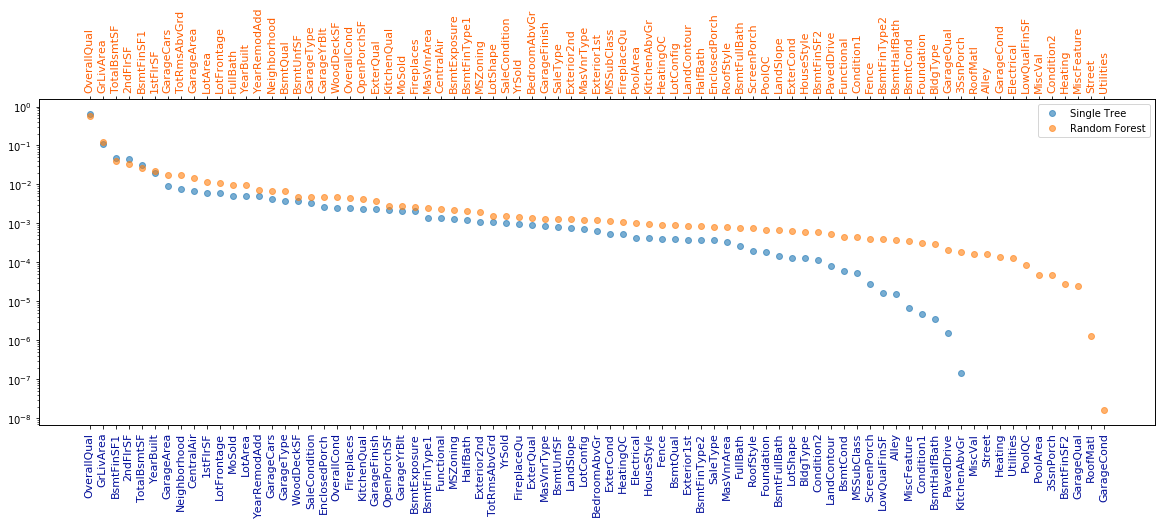

In [15]:
fig, ax =plt.subplots(figsize=(20,6))
ax.semilogy(np.sort(feature_importances_forest)[::-1],'o',label='Single Tree',alpha=0.6)
locs = ax.set_xticks(np.arange(len(kept_columnValues)))
ax.set_xticklabels(np.array(kept_columnValues)[sort_index_forest][::-1], rotation='vertical',fontsize=11)
[x.set_color('#000c99') for x in ax.get_xticklabels()]

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(kept_columnValues)))


ax.semilogy(np.sort(feature_importances)[::-1],'o',label='Random Forest',alpha=0.6)
ax2.set_xticks(np.arange(len(kept_columnValues)))
ax2.set_xticklabels(np.array(kept_columnValues)[sort_index][::-1], rotation='vertical',fontsize=11)
[x.set_color('#ff5d00') for x in ax2.get_xticklabels()]


pylab.ylabel("Feature Importance")
ax.legend()
plt.show()

In [16]:
sort_index_forest_desc = sort_index_forest[::-1]
test_errors = []
train_errors = []
#Study test error in respect to nb of feature selected
range_selection = range(1,len(sort_index_forest_desc))
for i in range_selection:
    selected_features = np.array(kept_columnValues)[sort_index_forest_desc[:i]]
    X_scaled_trimmed = X_scaled[selected_features]
    test_error,train_error,regressor = regressionTrees(X=X_scaled_trimmed,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)
    train_errors.append(train_error)
    test_errors.append(test_error)

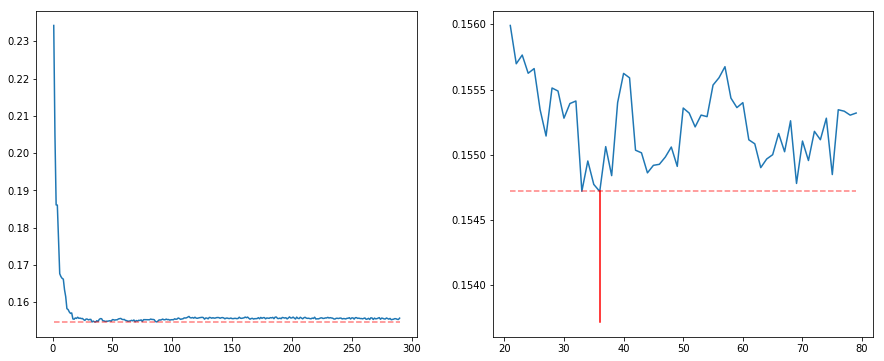

In [64]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range_selection,test_errors)
plt.plot(range_selection,[np.min(test_errors)]*len(range_selection),'r--',alpha=0.5)


plt.subplot(122)
min_slice = 20
max_slice = 79
argmin = np.argmin(test_errors)
plt.plot(range_selection[min_slice:max_slice],test_errors[min_slice:max_slice])
plt.plot(range_selection[min_slice:max_slice],[np.min(test_errors)]*len(range_selection[min_slice:max_slice]),'r--',alpha=0.5)
argmin = np.argmin(test_errors)
plt.plot([argmin+1,argmin+1],[np.min(test_errors)-0.001,np.min(test_errors)],'r')
plt.show()

In [17]:
selected_features = np.array(kept_columnValues)[sort_index_forest_desc[:np.argmin(test_errors)+1]]
X_scaled_trimmed = X_scaled[selected_features]
test_error,train_error,regressor = regressionTrees(X=X_scaled_trimmed,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)

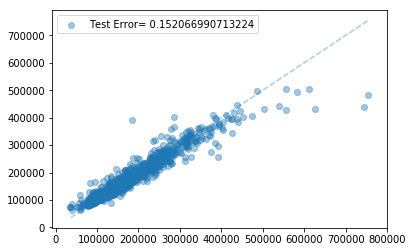

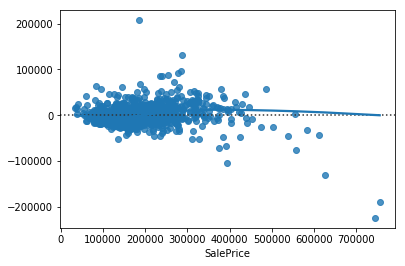

In [21]:
import seaborn as sns
plt.plot(Y,Y,'--',alpha=0.3,label="")
plt.scatter(Y,regressor.predict(X_scaled_trimmed),alpha=0.4,label="Test Error= "+str(test_error))
plt.legend()
plt.show()
plt.figure()
sns.residplot(Y,regressor.predict(X_scaled_trimmed),lowess=True)
plt.show()

## PCA

In [31]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X_scaled)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDf, Y], axis = 1)
finalDf.head()

,pc1,pc2,SalePrice
0,-4.167990,1.612516,208500
1,-0.123889,-3.241526,181500
2,-4.985214,0.897650,223500
3,1.556314,0.107976,140000
4,-6.642466,0.570435,250000


In [132]:
testerror,trainerror,regressor = regressionTrees(X=principalDf,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)

In [66]:
np.concatenate((regressor.predict(X),regressor.predict(X))).shape

(2400,)

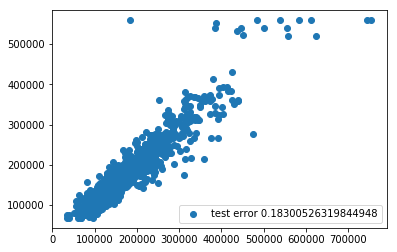

In [133]:
plt.scatter(Y,regressor.predict(principalDf),label='test error '+str(testerror))
plt.legend()
plt.show()

In [43]:
len(X.columns.values)

291

In [80]:
testErrors = []
for i in range(2,len(X.columns.values)):
    if not i%50:print(i)
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(X_scaled_array)
    principalDf = pd.DataFrame(data = principalComponents)
    testerror,trainerror,regressor = regressionTrees(X=principalDf,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)
    testErrors.append(testerror)

50
100
150
200
250


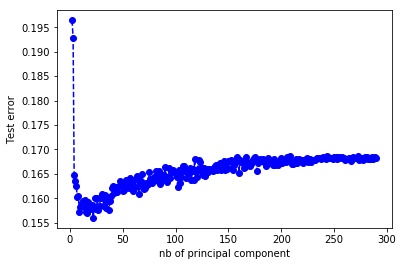

In [88]:
plt.plot(range(2,len(X.columns.values)),testErrors,'b--o')
plt.xlabel('nb of principal component')
plt.ylabel("Test error")
plt.show()

In [253]:
max(0,11)

11

In [29]:
def salePriceColor(hist,salePrice):
    index = [i for i,x in enumerate(hist[1]) if x<=salePrice][-1]
    return hist[0][max(0,index-1)]

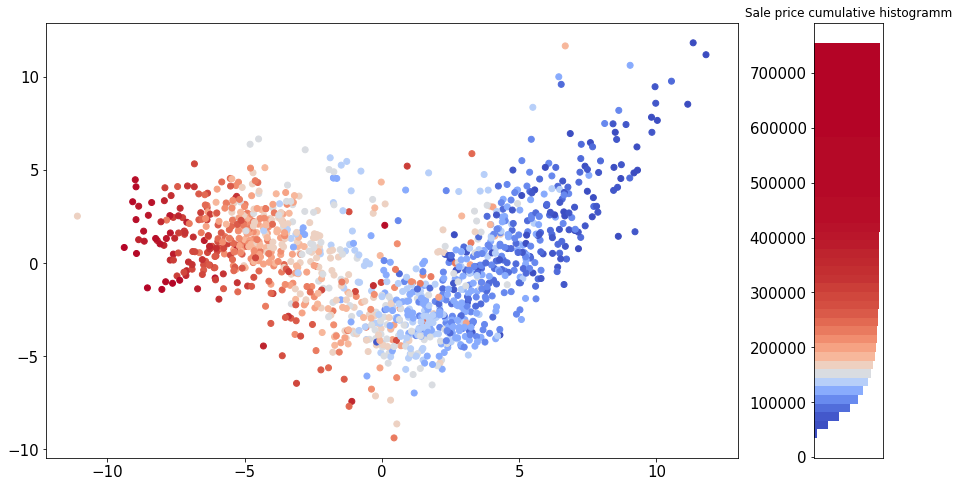

In [32]:
plt.figure(figsize=(15,8))
hist = plt.hist(Y,cumulative=True,normed=True,bins='auto')
for c, p in zip(hist[0], hist[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.clf()
plt.close()
def normHist(row):
    salePrice = row.SalePrice
    return salePriceColor(hist,salePrice)
colors = pdAllData.apply(normHist,axis=1)


plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])
plt.subplot(gs[0])
sc = plt.scatter(finalDf.pc1,finalDf.pc2,c=colors,cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.colorbar(sc,ticks=finalDf.SalePrice)
plt.subplot(gs[1])
histbis = plt.hist(finalDf.SalePrice,cumulative=True,normed=True,bins='auto',orientation='horizontal')
for c, p in zip(histbis[0], histbis[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.gca().set_xscale("log")
plt.title("Sale price cumulative histogramm")
plt.yticks(fontsize=15)
plt.tick_params(axis='x',which='both',bottom='off',labelbottom='off')
plt.show()

### Consider outliers

Automatically created module for IPython interactive environment


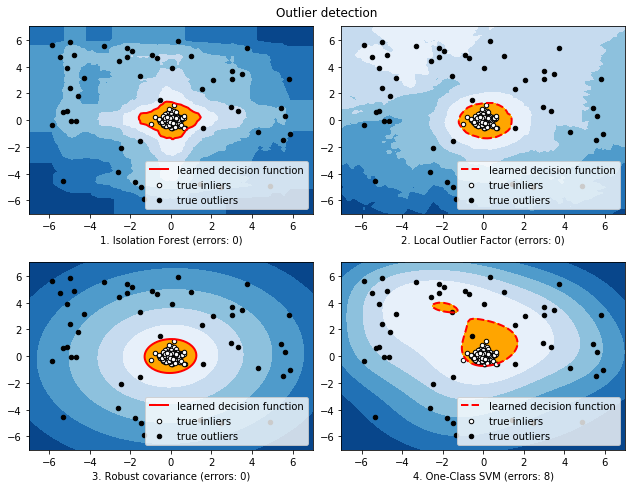

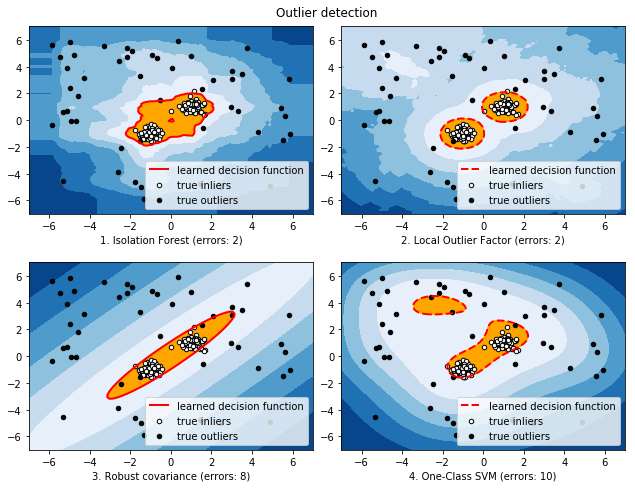

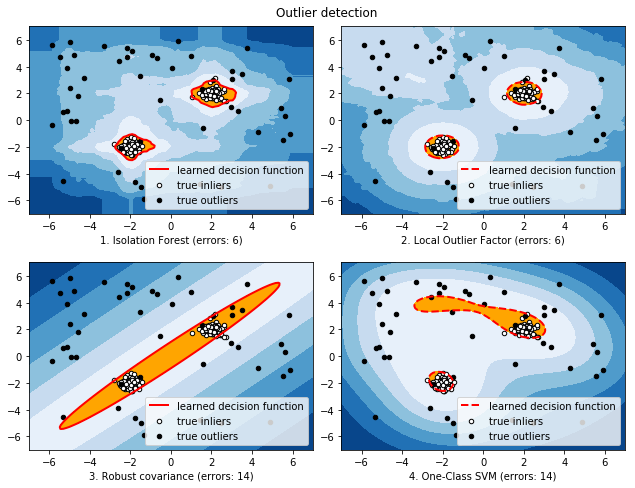

In [143]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(9, 7))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            
            
            
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        
        
        n_errors = (y_pred != ground_truth).sum()
        
        
        
        
        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

plt.show()

### Isolation forest

In [33]:
from sklearn.ensemble import IsolationForest
from scipy import stats

outliers_fraction = 0.05

def findOutliers_IsolationForest(X, outliers_fraction):
    clf = IsolationForest(max_samples=len(X), contamination=outliers_fraction, random_state=42)
    clf.fit(X)
    scores_pred = clf.decision_function(X)
    y_pred = clf.predict(X)
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    return scores_pred, y_pred, threshold

scores_pred, y_pred, threshold = findOutliers_IsolationForest(Y.values.reshape(-1,1), outliers_fraction)
#scores_pred, y_pred, threshold = findOutliers_IsolationForest(pdAllData, outliers_fraction)

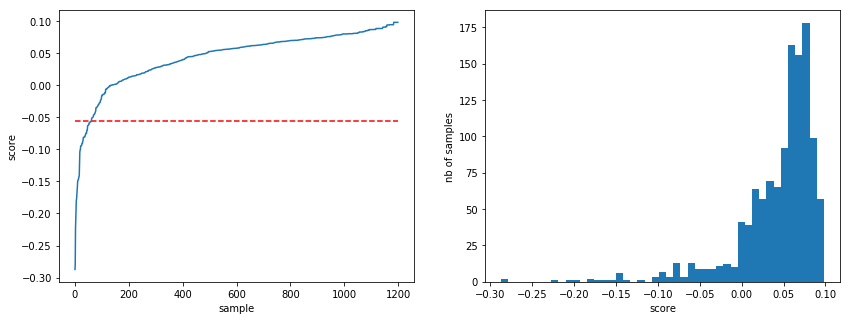

In [34]:
plt.figure(figsize=(14,5))
plt.subplot(121)
scores_pred_sorted = np.sort(scores_pred)
plt.plot([0,1199],[threshold]*2,'--',c='red')
plt.plot(scores_pred_sorted),plt.xlabel("sample"),plt.ylabel("score")
plt.subplot(122)
plt.hist(scores_pred_sorted, bins='auto'),plt.xlabel("score"),plt.ylabel("nb of samples")
plt.show()

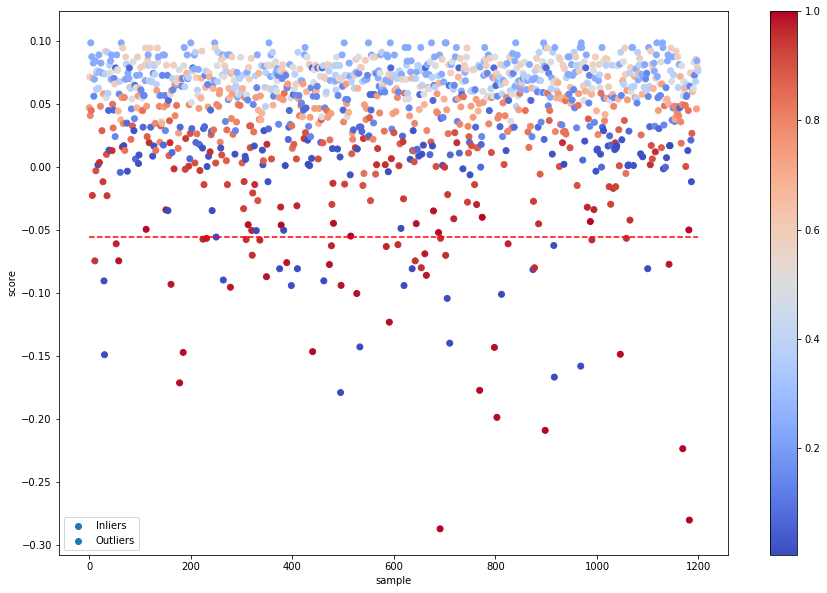

In [35]:
colors = pdAllData.apply(normHist,axis=1)
inlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==1])
outlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==-1])

plt.figure(figsize=(15,10))
plt.scatter(inlier.T[0],inlier.T[1],c=colors.filter(inlier.T[0]),cmap=cmap,label="Inliers")
plt.scatter(outlier.T[0],outlier.T[1],c=colors.filter(outlier.T[0]),cmap=cmap,label="Outliers")
plt.plot([0,1199],[threshold]*2,'--',c='red')
plt.colorbar()
plt.xlabel("sample")
plt.ylabel("score")
plt.legend()
plt.show()

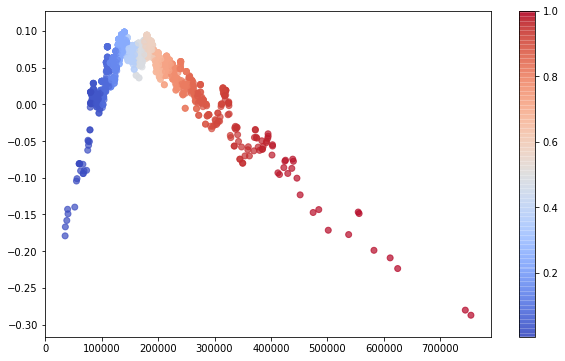

In [36]:
plt.figure(figsize=(10,6))
plt.scatter(Y,scores_pred,c=colors,cmap=cmap,alpha=0.7)
plt.colorbar()
plt.show()

In [37]:
scores_pred, y_pred, threshold = findOutliers_IsolationForest(Y.values.reshape(-1,1), outliers_fraction)
outlier_index = np.where(y_pred==-1)[0]
X_WO = X.drop(outlier_index)
Y_WO = Y.drop(outlier_index)
X_outliers = X.filter(outlier_index,axis=0)
Y_outliers = Y.filter(outlier_index,axis=0)
print(X_WO.shape,Y_WO.shape)
print(X_outliers.shape,Y_outliers.shape)
len(outlier_index)

(1140, 291) (1140,)
(60, 291) (60,)


60

In [39]:
X_scaled_array_WO = StandardScaler().fit_transform(X_WO)
X_scaled_WO = pd.DataFrame(X_scaled_array_WO,columns=kept_columnValues)
test_error,train_error,regressor = regressionTrees(X=X_scaled_WO,X_outliers=X_outliers,Y_outliers=Y_outliers,Y=Y_WO,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)

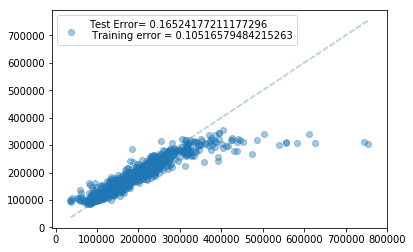

In [40]:
plt.plot(Y,Y,'--',alpha=0.3,label="")
plt.scatter(Y,regressor.predict(X_scaled),alpha=0.4,label="Test Error= "+str(test_error)+"\n Training error = "+str(train_error))
plt.legend()
plt.show()

In [23]:
testErrors = []
trainErrors = []

outliers_fractions = np.arange(0.03,0.5,0.05)

for outliers_fraction in outliers_fractions:
    scores_pred, y_pred, threshold = findOutliers_IsolationForest(pdAllData, outliers_fraction)
    outlier_index = np.where(y_pred==-1)[0]
    X_scaled_array = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)
    
    X_scaled_WO = X_scaled.drop(outlier_index)
    Y_WO = Y.drop(outlier_index)
    X_scaled_outliers = X_scaled.filter(outlier_index,axis=0)
    Y_outliers = Y.filter(outlier_index,axis=0)
    
    testerror, trainerror, regressor = regressionTrees(X=X_scaled_WO,X_outliers=X_scaled_outliers,Y_outliers=Y_outliers,Y=Y_WO,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)
    
    testErrors.append(testerror)
    trainErrors.append(trainerror)


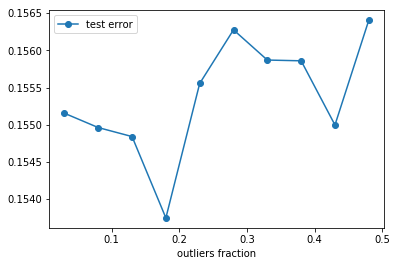

In [24]:
plt.plot(outliers_fractions,testErrors, '-o',label="test error")
#plt.plot(outliers_fractions,trainErrors, label="train error")
plt.xlabel("outliers fraction")
plt.legend()
plt.show()

### SOM

In [5]:
!pip install minisom

  Running setup.py bdist_wheel for minisom: started
  Running setup.py bdist_wheel for minisom: finished with status 'done'
  Stored in directory: C:\Users\gauti_000\AppData\Local\pip\Cache\wheels\bf\41\74\f249faec59290949ed0f67953dadb616efc3e6860c9dcba454
Successfully built minisom


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [148]:
X.shape

(1200, 79)

In [138]:
X_som = np.array(X)

In [171]:
som = MiniSom(128 ,128 , 79, sigma=2.5, learning_rate=0.5)
print("Training...")
som.train_random(X_som, 500)  # random training
print("\n...ready!")
coords = np.array([som.winner(x) for x in X_som])

Training...

...ready!


In [140]:
colors = pdAllData.apply(normHist,axis=1)
scores_pred, y_pred, threshold = findOutliers_IsolationForest(X, 0.05)

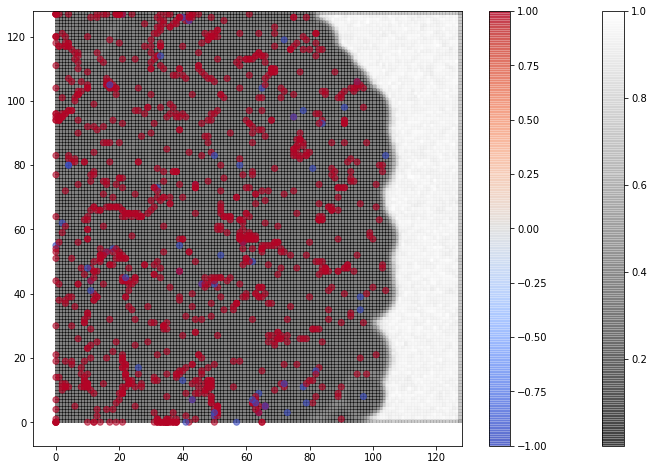

In [170]:
plt.figure(figsize=(12,8))
plt.pcolormesh(som.distance_map().T,alpha=0.5,cmap=cm.get_cmap('gist_gray'))  # plotting the distance map as background#plt.colorbar()
plt.colorbar()
plt.scatter(coords.T[0],coords.T[1],c=y_pred,cmap=cmap,alpha=0.6)
plt.colorbar()
plt.show()

In [ ]:
#OLD FUNCTION

def encodeCategoricalFeatures(Data,encoding_technique='labelEncode'):
    """Encode the input dataframe Data using the label or one hot encoding technique """
    data_frames =[]
    if encoding_technique=='labelEncode': #Label Encoding technique
        lb_make = LabelEncoder() #Sklearn automatic encoder
        for featureCol in Data:
            if Data[featureCol].dtype=='object': #Categorical Feature
                data_frames.append(pd.DataFrame(lb_make.fit_transform(Data[featureCol]),columns=[featureCol]))
            else:
                data_frames.append(Data[featureCol])
    elif encoding_technique == 'persoLabelEncodeOrdered':
        for featureCol in Data:
            if Data[featureCol].dtype=='object': #Categorical Feature
                data_frames.append(labelEncodingOrdered(Data[featureCol],Data.SalePrice))
            else: 
                data_frames.append(Data[featureCol])
    elif encoding_technique =='oneHotEncode':
        for featureCol in Data:
            if Data[featureCol].dtype=='object' and featureCol in SpecificVal:
                lb_style = LabelBinarizer()
                lb_results = lb_style.fit_transform(Data[featureCol])
                if(len(lb_style.classes_)==2):columnsNames = [featureCol] #Simple binarisation -> on column resulting for two classes 
                else: columnsNames = lb_style.classes_ #One columnfor each possible values 

                lb_results = pd.DataFrame(lb_results, columns=[featureCol+"_"+name for name in columnsNames])
                data_frames.append(lb_results)
            elif Data[featureCol].dtype=='object': #NA values in a number column
                lb_make = LabelEncoder()
                data_frames.append(pd.DataFrame(lb_make.fit_transform(Data[featureCol]),columns=[featureCol]))
            else:
                data_frames.append(Data[featureCol])
    else: raise Exception('Choose an encoding technique labelEncode=True or oneHotEncode=True')
    return pd.concat(data_frames,axis=1)    
 

In [ ]:
def preprocessing(pdAllData_Categ,pdTestData_Categ,scaling=True,encoding_technique='labelEncode'):
    #Encoding
    pdAllData = encodeCategoricalFeatures(pdAllData_Categ,encoding_technique)

    X = pdAllData.drop(['Id','SalePrice'],axis=1)
    Y = pdAllData.SalePrice
    #Scaling 
    kept_columnValues = list(X.columns.values)
    X_scaled_array = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)
    return X_scaled